# Calculate the AVR as a function of effective temperature.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Gaia-McQuillan crossmatch and make cuts.

In [2]:
gaia_mc0 = pd.read_csv("gaia_mc.csv")
print(np.shape(gaia_mc0))

# Cut out visual binaries.
gaia_mc1 = gaia_mc0.iloc[gaia_mc0.flag.values == 1]
print(np.shape(gaia_mc1), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc1.age.values > .5
print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars
m &= (gaia_mc1.color_teffs.values < 5000) * (3500 < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

gaia_mc = gaia_mc1.iloc[m]

(29727, 155)
(10544, 155) no visual binaries or subgiants
(10405, 155) no large vb uncertainties
(10274, 155) no faint stars
(9684, 155) no rapid rotators
(6820, 155) no hot or cold stars


Make cuts in log age.

In [4]:
age_bins = 10**np.linspace(np.log10(.5), np.log10(3.5), 7)
mid_age_bins = age_bins[:-1] + .5*np.diff(age_bins)
age_masks = select_stars(gaia_mc, age_bins, "age")

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Format data.

In [36]:
x = gaia_mc.color_teffs.values
y = gaia_mc.Prot.values
v = gaia_mc.vb.values
verr = gaia_mc.vb_err.values
xerr = np.ones_like(x)*100
xlim = (5100, 3100)

tbins = np.linspace(min(x), max(x), 10)
mid_tbins = .5*np.diff(tbins) + tbins[:-1]
ds, derrs = [np.zeros((len(age_bins), len(tbins[:-1]))) for i in range(2)]

Calculate dispersion as a function of age and temperature.

In [37]:
for i, m in enumerate(age_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    d, derr, k, kerr = MC_dispersion(x[m][clipping_mask], v_clipped, xerr[m][clipping_mask], 
                                     verr[m][clipping_mask],
                                     tbins, 1000, method="std")
    ds[i, :] = d
    derrs[i, :] = err_on_sample_std_dev(d, len(x[m][clipping_mask]))
#     derrs[i, :] = derr

  5%|▌         | 54/1000 [00:00<00:01, 534.34it/s]

niter =  3 7 stars removed kurtosis =  0.16494527576110318


  7%|▋         | 70/1000 [00:00<00:01, 691.24it/s]

niter =  2 3 stars removed kurtosis =  -0.3206058375939782


  7%|▋         | 71/1000 [00:00<00:01, 709.62it/s]

niter =  2 5 stars removed kurtosis =  -0.44023564009195715


  6%|▋         | 65/1000 [00:00<00:01, 647.69it/s]

niter =  2 4 stars removed kurtosis =  -0.03953171441661585


 13%|█▎        | 132/1000 [00:00<00:01, 645.75it/s]

niter =  3 13 stars removed kurtosis =  0.11288262025288498


  6%|▌         | 58/1000 [00:00<00:01, 573.09it/s]

niter =  3 14 stars removed kurtosis =  0.048021436188922184


100%|██████████| 1000/1000 [00:01<00:00, 638.42it/s]


Calculate the AVR for each temperature bin (ds = [age_bins, tbins-1]). Exclude the oldest and youngest bins from the fit.

Text(0, 0.5, '$\\mathrm{\\sigma_{vb}}$')

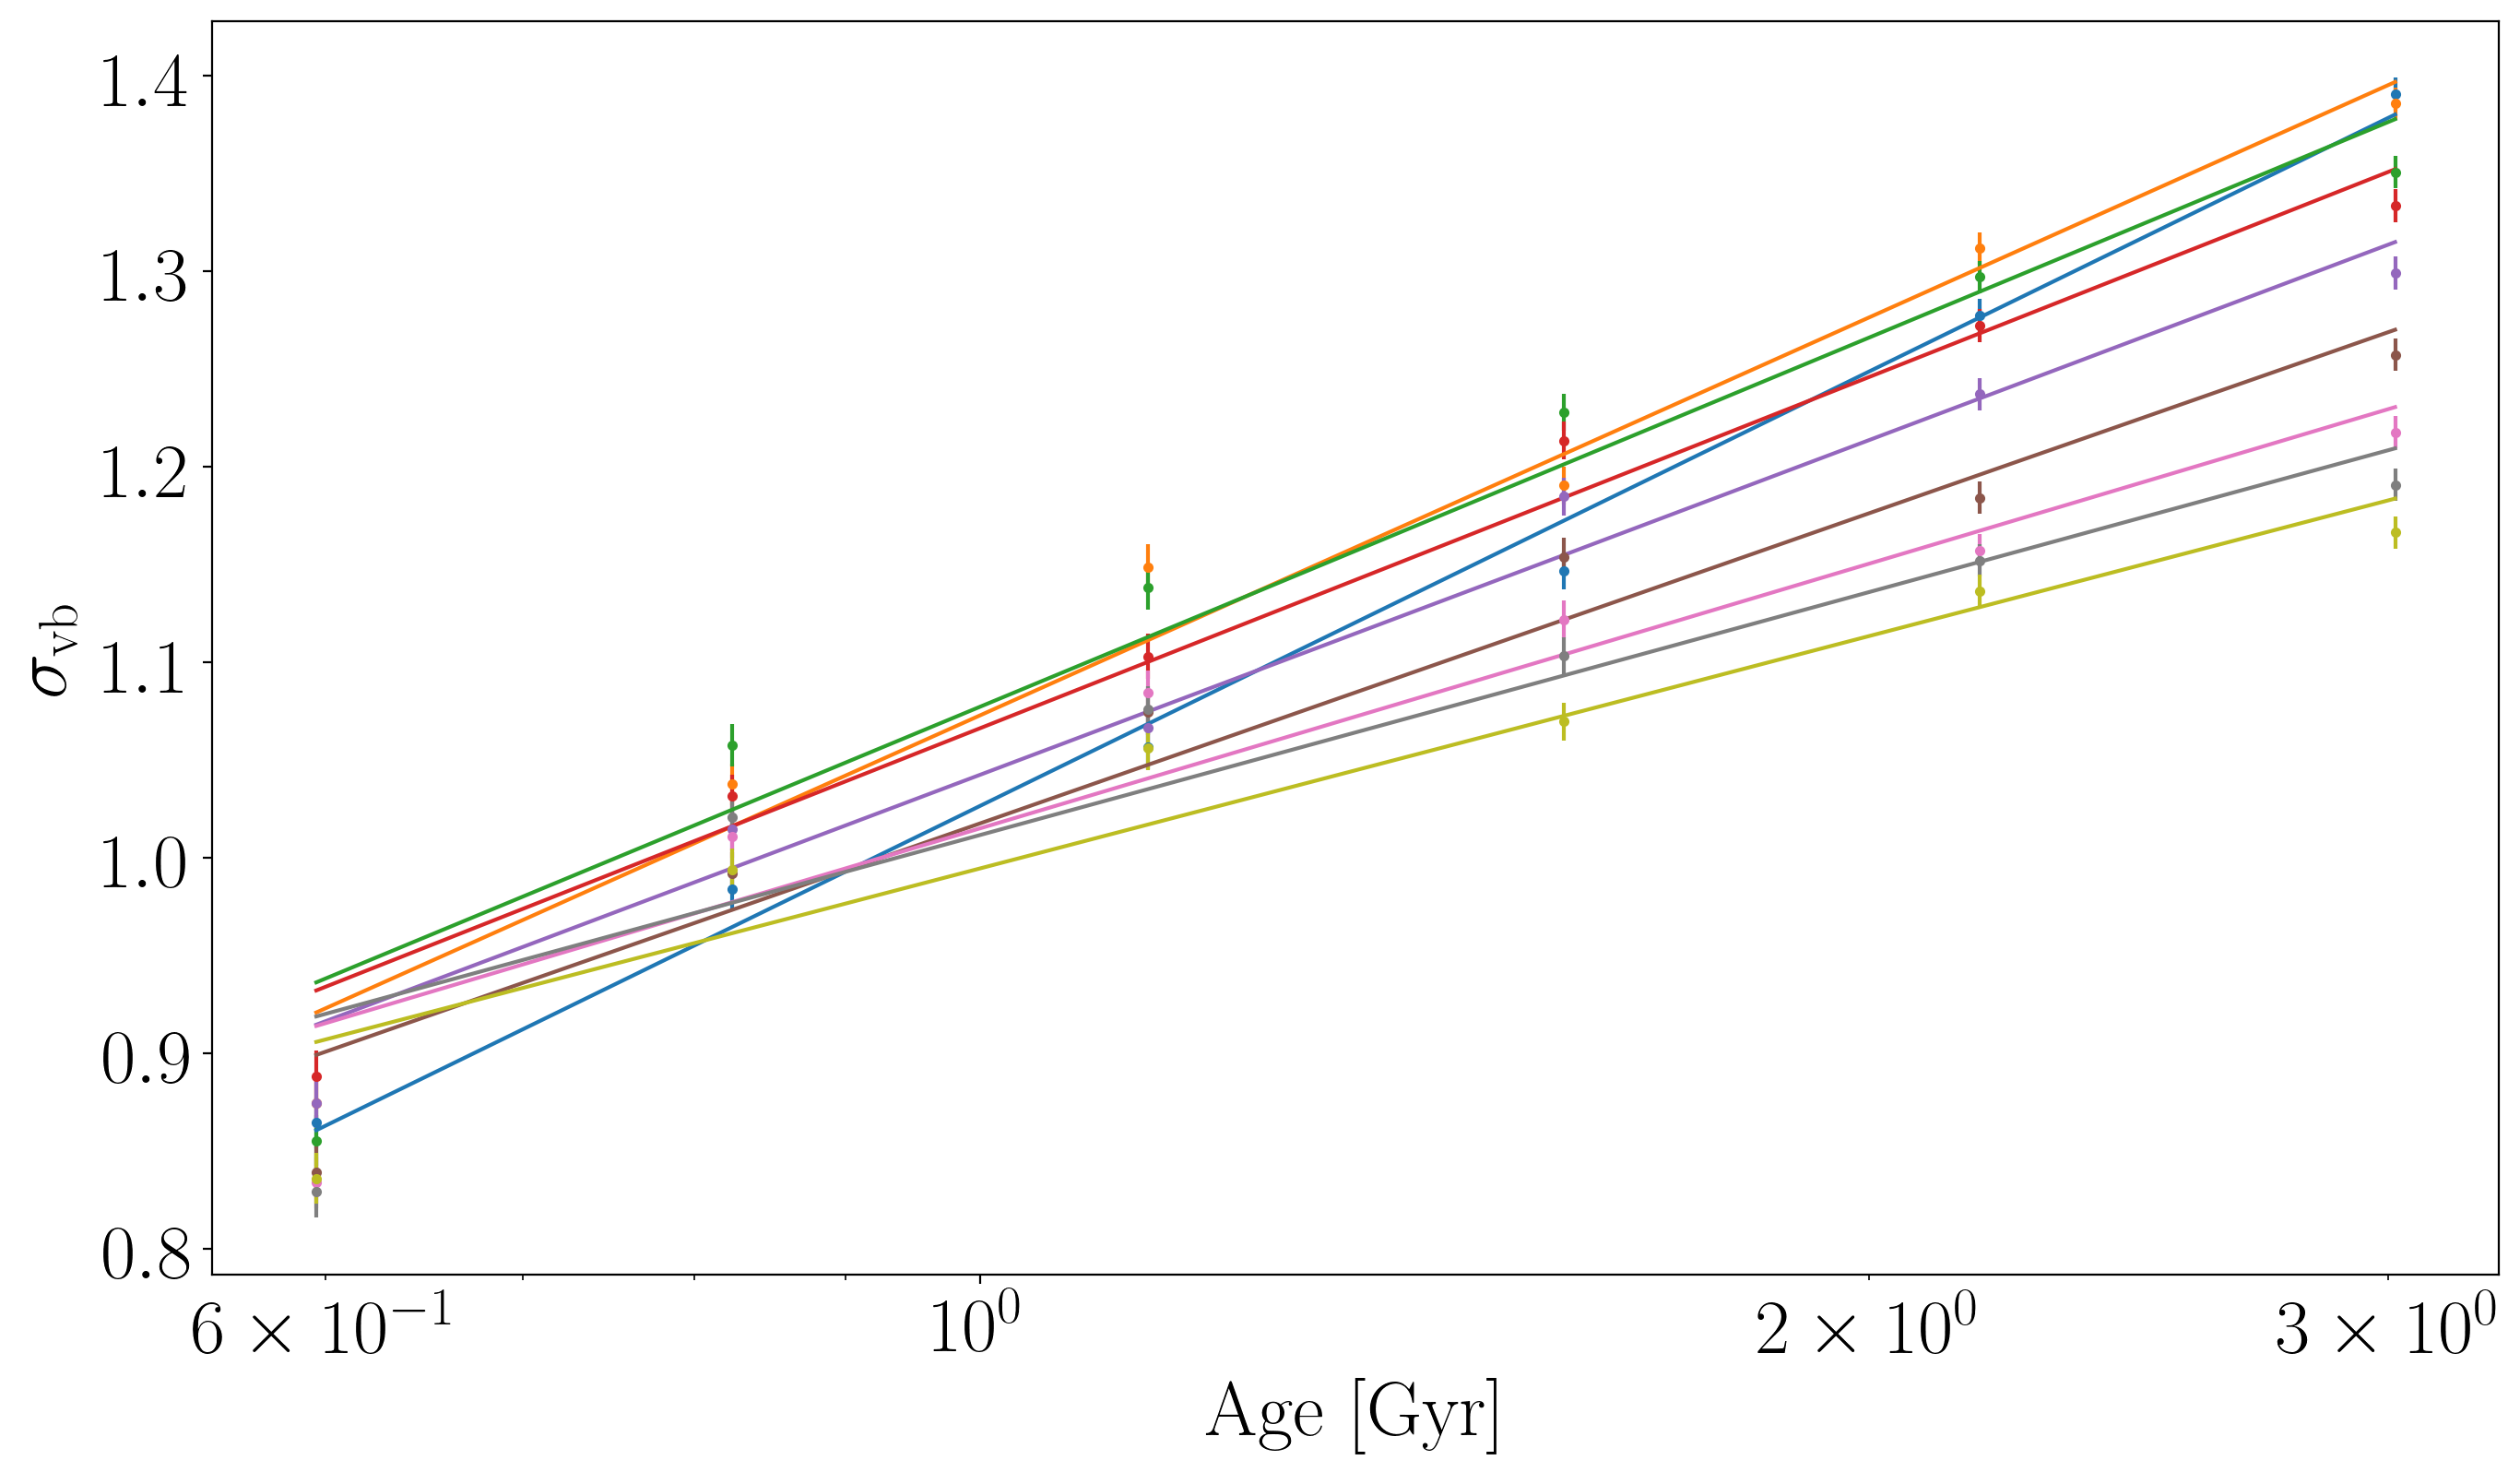

In [42]:
plt.figure(figsize=(16, 9), dpi=200)

x = (np.log10(mid_age_bins))
z = mid_tbins

w1s, w1errs = [np.zeros(len(z)) for i in range(2)]
for i in range(len(z)):
    
    y = np.log10(ds[:, i][:-1])
    yerr = err_to_log10_err(ds[:, i][:-1], derrs[:, i][:-1])
    
    w, wcovar = fit_line(x, y, yerr)
    w1s[i] = w[1]
    w1errs[i] = np.sqrt(wcovar[1, 1])
    
    plt.errorbar(10**x, y, yerr=yerr, fmt=".", color="C{}".format(i))
    plt.plot(10**x, w[0] + w[1]*x, color="C{}".format(i))

plt.xscale("log")
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{\sigma_{vb}}$")

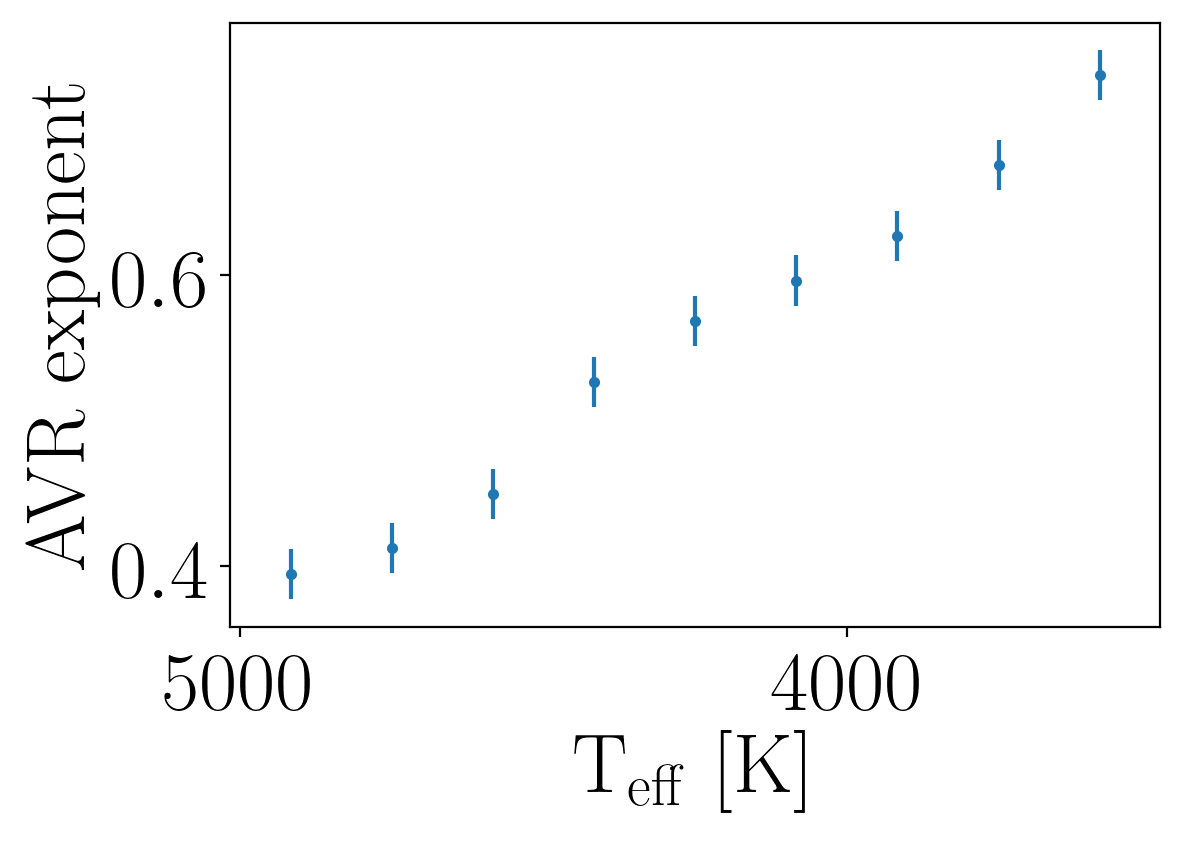

In [57]:
plt.figure(dpi=200)
plt.errorbar(mid_tbins, w1s, yerr=w1errs, fmt=".")
plt.xlim(max(mid_tbins)+100, min(mid_tbins)-100)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{AVR~exponent}$")
plt.savefig("paper/AVR_exponents.pdf")

In [58]:
print("minimum beta = {0:.2f} +\- {1:.2f}".format(w1s[-1], w1errs[-1]))
print("maximum beta = {0:.2f} +\- {1:.2f}".format(w1s[0], w1errs[0]))

minimum beta = 0.39 +\- 0.02
maximum beta = 0.74 +\- 0.02
